# Data Preprocessing Notebook

# Introduction

The initial dataset being sourced is from the HuggingFace library, (https://huggingface.co/datasets/brianarbuckle/cocktail_recipes)

This initial dataset contains columns `title`, `ingredients`, `directions`, `misc`, `source`, and `ner`.

**Overview**
The 'Ingredients' column of our dataset presents a unique challenge. It consists of objects, each being a list of strings, where each string details a part of a cocktail recipe. These details typically include the quantity, unit, and name of an ingredient, but they can also contain preparation instructions or garnishing details that are not directly usable in their current form for data analysis or recipe generation.

**Objective**
Our goal is to parse these strings to extract structured information that can be effectively utilized in our project. Specifically, we aim to separate the ingredient details into distinct components: quantity, unit, and ingredient name, while filtering out the non-ingredient related information.

## Imports

In [81]:
import pandas as pd
import re
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

pip install datasetsto access HuggingFace datasets library

In [82]:
#!pip install datasets

# Initial Data Inspection

In [83]:
# Loading the cocktail_recipes dataset
dataset = load_dataset('brianarbuckle/cocktail_recipes')

In [84]:
df = pd.DataFrame(dataset['train'])

In [85]:
df.head(5)

,title,ingredients,directions,misc,source,ner
0,151 Swizzle,[1.5 oz. 151-Proof Demerara Rum [Lemon Hart or...,[],[],Beachbum Berry Remixed,"[pernod, rum]"
1,20th Century,"[The 21st Century, 2 oz. Siete Leguas Blanco T...","[shake on ice and strain into coupe , The Best...",[],Jim Meehan,"[cocchi americano, pernod, tequila]"
2,20th Century,"[1.5 oz. Plymouth Gin, 3\/4 oz. Mari Brizard W...",[shake on ice and strain],[],PDT,"[lillet, gin]"
3,Abbey Cocktail,[],"[Shake liquid ingredients with ice., Strain in...",[Suggested glassware is Cocktail Glass],The Ultimate Bar Book,[]
4,Absinthe Drip,[1 1/2 ounces Pernod (or other absinthe substi...,[Pour Pernod into a pousse-caf or sour glass....,[The Absinthe Drip was made famous by Toulouse...,The Ultimate Bar Book,"[pernod, absinthe]"


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 875 entries, 0 to 874
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        875 non-null    object
 1   ingredients  875 non-null    object
 2   directions   875 non-null    object
 3   misc         875 non-null    object
 4   source       875 non-null    object
 5   ner          875 non-null    object
dtypes: object(6)
memory usage: 41.1+ KB


In [87]:
df.shape

(875, 6)

From this **Initial Data Inspection**, we see that the data is a 875 x 6 dataframe, entirely of objects. We also get to see that there are multiple instances of entries being `[]` constiting non-null entries.

# Data Cleaning

Section involves removing empty rows, rows irrelevant to the analysis, or any rows unusable in the analysis.

In [88]:
# Removing rows where `ingredients` is empty
non_empty_ingredients_df = df[df['ingredients'].apply(lambda x: len(x) > 0)]
modified_df = non_empty_ingredients_df.reset_index(drop=True)

In [89]:
modified_df.shape

(873, 6)

From this, we can see that the dataframe went from 875 → 873 rows. So only two rows contained no information in the ingredients section. 

# Deleting problematic rows

In [90]:
# Drop row from the DataFrame, Reset the index --
modified_df = modified_df.drop(index=7).reset_index(drop=True)        # Industrial recipe

# Parsing 'Ingredients'

This section will involve parsing the 'Ingredients' column in order to obtain data relevant to the project, and organize it such that it can be utilized.

For example, the current 'ingredients' column contains data such as:

In [91]:
modified_df['ingredients'][0]

['1.5 oz. 151-Proof Demerara Rum [Lemon Hart or El Dorado]',
 '0.5 oz. Lime Juice',
 '0.5 oz. Sugar Syrup',
 '1 Dash Angostura Bitters',
 '6 drops [1\\/8 Tsp.] Pernod',
 '8 oz. crushed ice',
 'blend at high speed for 5 seconds, pour into metal cup or a pilsner glass',
 'Garnish with dust of nutmeg and a cinnamon stick']

## Analysis

- **Ingredient Entries**: Most strings follow a common format: `[quantity] [unit] [ingredient]`, which allows for standardized extraction. For example, `1.5 oz. 151-Proof Demerara Rum [Lemon Hart or El Dorado]` contains clear quantity, unit, and ingredient name components.

- **Non-Ingredient Instructions**: Some strings contain instructions or garnishing details, such as `blend at high speed for 5 seconds, pour into metal cup or a pilsner glass`, which do not fit the standard ingredient format and are thus considered unusable for direct ingredient analysis.


## Strategy
To tackle this, we employ a parsing function that utilizes regular expressions to identify and extract the quantity, unit, and ingredient name from each string, while discarding any non-ingredient information. This function is designed to handle the common format efficiently and includes error handling for strings that do not conform to the expected pattern.

By parsing the 'Ingredients' column in this manner, we aim to create a structured and usable dataset that will serve as a solid foundation for the subsequent stages of our project, including data analysis and the generation of new cocktail recipes.

In [92]:
def parse_ingredient(ingredient_str, step_index):
    # Pre-process to correct known formatting issues
    corrected_str = re.sub(r'\\', '', ingredient_str)  # Remove backslashes that might interfere with parsing
    corrected_str = corrected_str.strip()
    
    pattern = re.compile(
        r'(?P<quantity>\d+\s*\d*\/\d+|\d*\.\d+|\d+)?\s*'  # Capture quantities, fractions, decimals
        r'(?P<unit>oz|ounces?|tsp|teaspoons?|tablespoons?|tbl|tbs|cups?|pints?|quarts?|gallons?|lbs?|pounds?|ml|mL|liters?|dash|dashes|drops?|pinch|pinches|qt|qts|cl)?\.?\s*' 
        r'(?P<ingredient>.+)', re.IGNORECASE)

    match = pattern.match(corrected_str)
    
    if match:
        # Normalize unit names
        unit = match.group('unit')
        if unit:
            unit = unit.lower()
            if unit in ['tsp', 'teaspoons']:
                unit = 'tsp'
            elif unit in ['tbl', 'tbs', 'tablespoons']:
                unit = 'tbsp'
            elif unit in ['pounds', 'pound', 'lbs']:
                unit = 'lb'
            elif unit in ['gallons', 'gallon']:
                unit = 'gal'
            elif unit in ['ounces', 'ounce', 'oz']:
                unit = 'oz'
            elif unit in ['milliliters', 'millilitre', 'ml', 'mL']:
                unit = 'ml'
            elif unit in ['liters', 'litre']:
                unit = 'l'
            elif unit in ['qt', 'qts']:  
                unit = 'qt'
        
        return {
            'quantity': match.group('quantity'), 
            'unit': unit, 
            'ingredient': match.group('ingredient').strip(), 
            'ingredient_step': step_index
        }
    else:
        # Handling cases that don't fit the expected pattern
        return {
            'quantity': None, 
            'unit': None, 
            'ingredient': corrected_str, 
            'ingredient_step': step_index
        }

In [93]:
parsed_ingredients_list = []

In [94]:
for index, row in modified_df.iterrows():
    for idx, ingredient in enumerate(row['ingredients']):
        parsed_ingredient = parse_ingredient(ingredient, idx)
        parsed_ingredient['recipe_id'] = index  # Adding the recipe ID to each ingredient
        parsed_ingredients_list.append(parsed_ingredient)

# Convert the list of dictionaries into a DataFrame
parsed_df = pd.DataFrame(parsed_ingredients_list)

We have created `parsed_df` which contains the parsed versions of the `ingredients` column of the original dataset.

In [95]:
parsed_df.shape

(3713, 5)

# Below this is troubleshooting to update the parsing
**Edge case detection**

Used to look into the `parsed_df` in order to find edge cases not yet listed into the regex, or potential manual cases required.

**Quick overview for identifying remaining cases.**

In [96]:
parsed_df.head(50)

,quantity,unit,ingredient,ingredient_step,recipe_id
0,1.5,oz,151-Proof Demerara Rum [Lemon Hart or El Dorado],0,0
1,0.5,oz,Lime Juice,1,0
2,0.5,oz,Sugar Syrup,2,0
3,1,dash,Angostura Bitters,3,0
4,6,drops,[1/8 Tsp.] Pernod,4,0
5,8,oz,crushed ice,5,0
6,None,None,"blend at high speed for 5 seconds, pour into m...",6,0
7,None,None,Garnish with dust of nutmeg and a cinnamon stick,7,0
8,None,None,The 21st Century,0,1
9,2,oz,Siete Leguas Blanco Tequila,1,1


**Used for analyzing edge cases:**

In [97]:
def inspect_row(modified_df, parsed_df, row_index):
    """
    Prints the title, ingredients, and directions of a given row in the modified DataFrame,
    and then prints all corresponding parsed ingredient rows from the parsed DataFrame.
    
    Parameters:
    - modified_df: pandas DataFrame containing the original cocktail data.
    - parsed_df: pandas DataFrame containing the parsed ingredients data.
    - row_index: Integer index of the row to inspect in modified_df and to match in parsed_df.
    """
    # Print details from the modified DataFrame
    print(f"Title: {modified_df.loc[row_index, 'title']}\n")
    print("Ingredients:")
    for ingredient in modified_df.loc[row_index, 'ingredients']:
        print(f"- {ingredient}")
    print("\nDirections:")
    for direction in modified_df.loc[row_index, 'directions']:
        print(f"- {direction}")
    
    # Print corresponding rows from the parsed DataFrame
    print("\nParsed Ingredients:")
    parsed_rows = parsed_df[parsed_df['recipe_id'] == row_index]
    if not parsed_rows.empty:
        print(parsed_rows.to_string(index=False))
    else:
        print("No parsed ingredients found for this recipe.")

In [98]:
# Example usage:
questionable_row = 871
inspect_row(modified_df, parsed_df, questionable_row)

Title: the-ontocord-mimosa

Ingredients:
- champagne
- orange juice-ish
- optional but preferable 1 oz. gin

Directions:
- Nearly fill a champagne flute with champagne.
- Make a show of adding the orange juice with a quick jerky motion - don't worry if no OJ gets in the drink, this in not the point.
- Furtively, add as much Gin as possible.
- Garnish with an orange slice.

Parsed Ingredients:
quantity unit                        ingredient  ingredient_step  recipe_id
    None None                         champagne                0        871
    None None                  orange juice-ish                1        871
    None None optional but preferable 1 oz. gin                2        871


**Looking into rows which arent formatted for use**

Looking into remaining edge cases, if something appears in the following, that means the quantity or unit is not successfully integrated by the parsing above.

In [99]:
# Filter rows and reset index 
none_rows = parsed_df.loc[parsed_df['quantity'].isnull() | parsed_df['unit'].isnull()].reset_index(drop=True)

# Display the filtered dataframe
none_rows

,quantity,unit,ingredient,ingredient_step,recipe_id
0,None,None,"blend at high speed for 5 seconds, pour into m...",6,0
1,None,None,Garnish with dust of nutmeg and a cinnamon stick,7,0
2,None,None,The 21st Century,0,1
3,None,None,rinse coupe glass with Pernod,4,1
4,1,None,sugar cube,1,3
...,...,...,...,...,...
1342,None,None,,9,867
1343,None,None,"shake on ice and strain""",5,870
1344,None,None,champagne,0,871
1345,None,None,orange juice-ish,1,871


**Tracking to make sure rows is decreasing post-changes**

1347

In [100]:
# Filter rows where 'ingredient' contains 'optional'
optional_ingredients = none_rows[none_rows['ingredient'].str.contains('optional', case=False, na=False)].reset_index(drop=True)

# Display the filtered dataframe
optional_ingredients

,quantity,unit,ingredient,ingredient_step,recipe_id
0,None,None,Whipped cream topper (optional),3,132
1,2,None,to 3 ounces chilled club soda (optional),5,189
2,None,None,Chocolate shavings (optional),5,192
3,None,dash,of Angostura bitters (optional),2,370
4,None,None,• 2 Dashes Gum Syrup (optional),19,481
5,6,None,lemon twists (optional),6,510
6,None,None,Lemon twist (optional),4,531
7,4,None,small pink orchids (optional),7,581
8,None,None,Peychauds Bitters to taste (optional),2,657
9,1,None,egg white (optional),3,672


**Use to look into row in none_df**

    Can help find recipie_id in parsed_df, as well as identify problematic sections with the row

In [101]:
none_rows.iloc[1346]

quantity                                        None
unit                                            None
ingredient         optional but preferable 1 oz. gin
ingredient_step                                    2
recipe_id                                        871
Name: 1346, dtype: object

**Visual of parsed_df's units**
Notable insights: 

    -mainly oz (sources are likely American)
    -Can help view None columns as a chunk
    -gives an insight into the more unique measurements such as `dash`, `tsp`, etc.

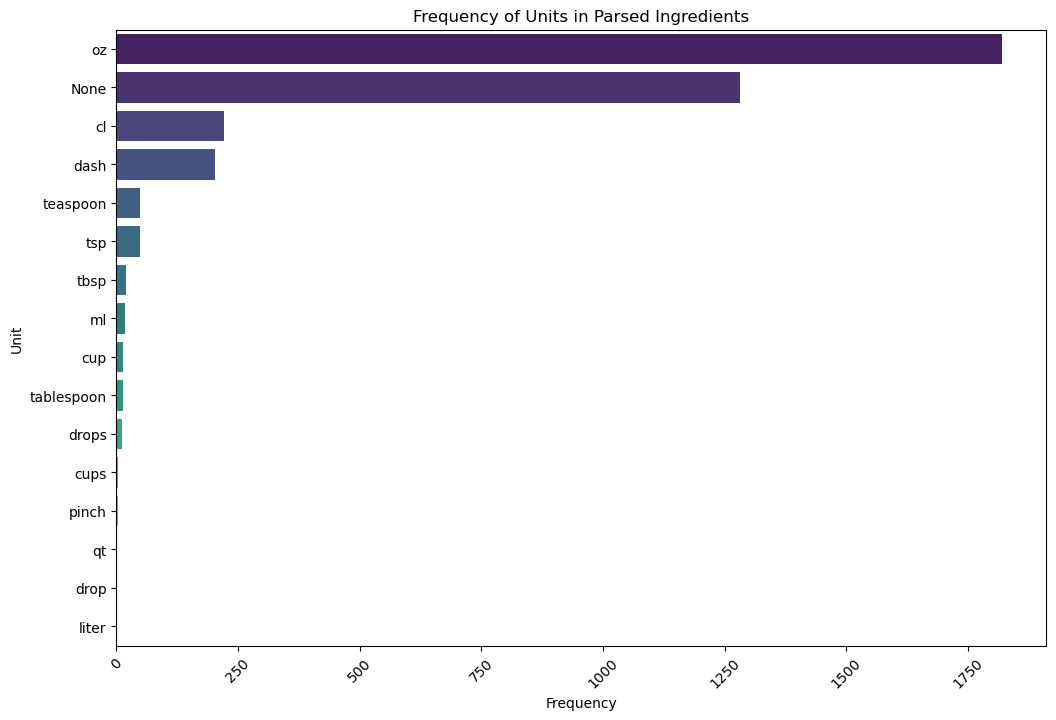

In [102]:
# Count the frequency of each unit, including None (NaN) values
unit_counts = parsed_df['unit'].value_counts(dropna=False)

# replace NaN (None) with a string for visualization purposes:
unit_counts.index = unit_counts.index.fillna('None')

# Create a bar chart
plt.figure(figsize=(12, 8))  
sns.barplot(x=unit_counts.values, y=unit_counts.index, palette="viridis", orient='h')  # Use horizontal bars

plt.title('Frequency of Units in Parsed Ingredients')
plt.ylabel('Unit')  # For horizontal bars, the y-axis now represents units
plt.xlabel('Frequency')
plt.xticks(rotation=45) 

plt.show()

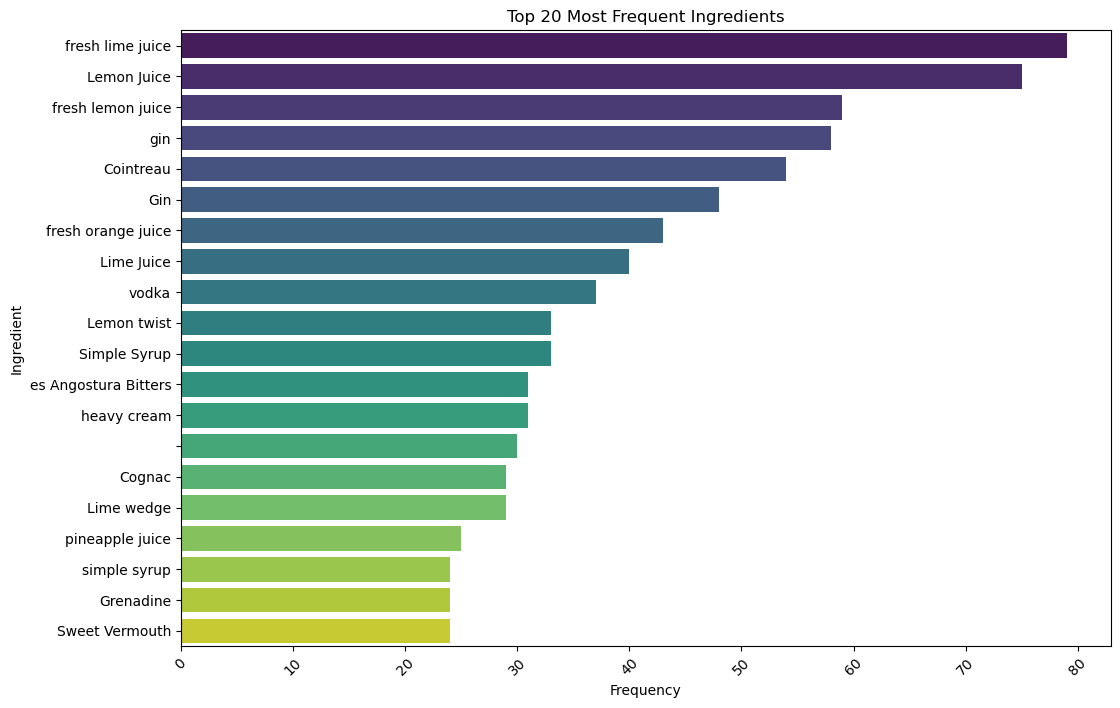

In [103]:
# Sort the dataframe by ingredient frequency (descending)
top_20_ingredients = parsed_df.groupby('ingredient')['ingredient'].count().sort_values(ascending=False).head(20)

# Create the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=top_20_ingredients.values, y=top_20_ingredients.index, palette="viridis", orient='h')

plt.title('Top 20 Most Frequent Ingredients')
plt.ylabel('Ingredient')  # Label for horizontal bars
plt.xlabel('Frequency')
plt.xticks(rotation=45)

plt.show()